# Malicious DNS-over-HTTP Traffic Detection with Anomaly Detection Machine Learning

Welcome to this Jupyter Notebook! We will explore the use of anomaly detection machine learning techniques to detect malicious DoH traffic. The notebook will guide your through loading a DoH traffic dataset, preparing the datasets, training machine learning models, and evaluating their effectiveness in identifying malicious traffic. 

## The anomaly detection machine learning workflow

The steps to train and use an anomaly detection machine learning model are usually as follows: 
 1. Load data
 2. Prepare training and testing datasets for training phase. These dataset only include normal data. 
 3. Prepare an evaluation dataset that contains both normal and malicious data. 
 4. Run a training algorithm using the training and testing dataset.
 5. Run inference with he trained ML model using the testing dataset.
 6. Visualize and evaluate the ML model's performance
 
The rest of this notebook will follow these steps to train anomaly detection (i.e., semi-supervised) machine learning models) to detect malicious DoH traffic.  

## Load the DoH traffic data
We start by loading two existing datasets of statistical features of TCP connections carrying DoH traffic into a Pandas dataframe. One dataset contains normal traffic and the other one malcicious traffic. 

The datasets are in CSV format with a column for each feature. The Pandas dataframe allows us to read the CSV file into a Python data structure that is very similar to an Excel sheet. 

In [106]:
# The file that contains the normal DoH traffic data. In this case, we are using the traffic generated 
# using the Cloudflare dataset.
normal_doh_traffic_dataset = 'doh_traffic_datasets/normal_doh_traffic_cloudflare_server.csv'

# The file that contains the malicious DoH traffic. We are using DoH traffic that carries a dnscat 
# tunnel for data exfiltration. 
malicious_doh_traffic_dataset = 'doh_traffic_datasets/dnscat2_data_4.csv'

# Import the pandas library
import pandas as pd

# Load the datasets into Pandas dataframes
normal_traffic_df    = pd.read_csv(normal_doh_traffic_dataset)
malicious_traffic_df = pd.read_csv(malicious_doh_traffic_dataset)

### Lets see what we have in the dataframes

In [107]:
normal_traffic_df

,bytes_out,num_pkts_out,bytes_in,num_pkts_in,bytes_ration,num_pkts_ration,time,av_pkt_size_in,av_pkt_size_out,var_pkt_size_in,var_pkt_size_out,median_in,median_out,mindelay,avgdelay,maxdelay,is_doh
0,0.038207,0.040566,0.037993,0.042252,0.330945,0.666667,0.142261,0.161100,0.446486,0.029621,0.089444,0.271106,0.446486,0.0,0.156132,0.138663,1
1,0.158368,0.164492,0.157195,0.165296,0.330548,0.643651,0.368210,0.179073,0.482115,0.031426,0.088050,0.286723,0.482115,0.0,0.101448,0.138796,1
2,0.444930,0.461775,0.413861,0.452236,0.309801,0.627386,0.999888,0.166632,0.483418,0.026398,0.095197,0.275913,0.483418,0.0,0.099373,0.138832,1
3,0.132261,0.153362,0.135935,0.157628,0.342253,0.658327,0.999999,0.148324,0.312008,0.036691,0.085530,0.260006,0.312008,0.0,0.292235,0.193173,1
4,0.129911,0.151098,0.133228,0.155072,0.341502,0.657356,0.999391,0.147198,0.307559,0.035029,0.083906,0.259027,0.307559,0.0,0.296651,0.138849,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2345,0.245127,0.262281,0.246135,0.271685,0.334409,0.663545,0.999645,0.163445,0.434373,0.035066,0.089048,0.273144,0.434373,0.0,0.170155,0.272727,1
2346,0.300659,0.314975,0.313175,0.327676,0.346911,0.666423,0.999829,0.180722,0.468194,0.035075,0.090260,0.288155,0.468194,0.0,0.141410,0.272718,1
2347,0.140337,0.164377,0.128410,0.162061,0.304705,0.631497,0.999655,0.124026,0.297336,0.026048,0.078014,0.238894,0.297336,0.0,0.278195,0.138841,1
2348,0.089373,0.111913,0.078803,0.116054,0.293583,0.664153,0.999880,0.084697,0.203864,0.020469,0.071056,0.204722,0.203864,0.0,0.398651,0.272718,1


In [109]:
malicious_traffic_df

,bytes_out,num_pkts_out,bytes_in,num_pkts_in,bytes_ration,num_pkts_ration,time,av_pkt_size_in,av_pkt_size_out,var_pkt_size_in,var_pkt_size_out,median_in,median_out,mindelay,avgdelay,maxdelay,is_doh
0,0.008161,0.007220,0.005402,0.004601,0.015788,0.472420,0.109359,0.014784,0.219169,0.000845,0.043973,0.024431,0.219169,0.0,0.025787,0.133319,4
1,0.007925,0.007001,0.005310,0.004494,0.015971,0.475742,0.108966,0.014937,0.219992,0.001648,0.042766,0.024583,0.219992,0.0,0.026402,0.133434,4
2,0.007927,0.007001,0.005307,0.004494,0.015957,0.475742,0.108686,0.014924,0.220146,0.001648,0.042823,0.024570,0.220146,0.0,0.026335,0.133194,4
3,0.033504,0.029209,0.030564,0.018976,0.022046,0.484338,0.109759,0.023958,0.222640,0.000929,0.040278,0.033516,0.222640,0.0,0.006337,0.133176,4
4,0.052905,0.046056,0.049718,0.029998,0.022747,0.485913,0.109686,0.024939,0.222903,0.000833,0.039963,0.034487,0.222903,0.0,0.004011,0.135245,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10293,0.004841,0.003884,0.004026,0.002390,0.019600,0.453245,0.244249,0.025513,0.271441,0.003665,0.101614,0.035055,0.271441,0.0,0.108927,0.134632,4
10294,0.004591,0.003774,0.004010,0.002354,0.020557,0.459236,0.244362,0.025910,0.259148,0.003712,0.099855,0.035449,0.259148,0.0,0.111400,0.134135,4
10295,0.486491,0.485395,0.618845,0.440414,0.030865,0.677616,0.818411,0.019639,0.160669,0.000732,0.038659,0.029239,0.160669,0.0,0.002374,0.008762,4
10296,0.005056,0.005360,0.003792,0.003424,0.017697,0.472309,0.511998,0.013381,0.142958,0.001235,0.079285,0.023042,0.142958,0.0,0.162424,0.133958,4


### The contents of the dataset

We see that the normal and malicious datasets have 16 columns labeled 0 to 15. These columns are statistical features of the TCP connections related to round trip times, number of bytes, number of packets, etc. We explain what these columns mean in our data exploration notebook.

The is_doh column indicates the type of traffic. We have 1 for normal traffic and number higher than 1 for malicious traffic.  

## Preparing the datasets

We now prepare our training, testing, and evaluation datasets. Our training and testing datasets will only contain normal traffic to simulate a scenario where we primarily have access to normal traffic when training the ML models. Our evaluation dataset will contain both normal and malicious traffic to make sure that the ML models can identify both types of traffic during deployment. 

### The training and testing datasets
These datasets only contain normal data. The ML model is initially trained with the training dataset. We then evalaute how well the ML model can identify normal traffic that is not in the training dataset, i.e., traffic it may encouter during deployment. The performance of the model under the testing data guides our training process for deep larning models.  

In [150]:
# Get the label column from the training dataset
label_col = 'is_doh'
normal_labels = normal_traffic_df[label_col] # Only needed for creating training dataset. Not used in training

# Convert normal dataframe to numpy array. Drop label column. Turns out that the ML training libraries like
# Numpy arrays better than dataframes. 
import numpy as np
normal_traffic  = normal_traffic_df.drop(columns=label_col)

# Split the data into training and testing sets. Resulting dataframes will be randomized
from sklearn.model_selection import train_test_split

split = 0.2 # We are assigning 20% of the data for testing
data_training, data_testing, _, _= train_test_split(normal_traffic, normal_labels, test_size =split, random_state=1 )

# Save the datasets for later
data_training.to_csv('data_training.csv', index=False)
data_testing.to_csv('data_testing.csv', index=False)

### Lets see how our datasets look now

In [117]:
data_testing

,bytes_out,num_pkts_out,bytes_in,num_pkts_in,bytes_ration,num_pkts_ration,time,av_pkt_size_in,av_pkt_size_out,var_pkt_size_in,var_pkt_size_out,median_in,median_out,mindelay,avgdelay,maxdelay
1832,0.000258,0.000269,0.000870,0.000280,0.999707,0.583333,0.001202,0.928571,0.449892,0.999527,0.645340,0.937938,0.449892,0.0,0.199285,0.135316
1249,0.000689,0.000652,0.001200,0.000599,0.554446,0.555556,0.000614,0.543985,0.618569,0.510285,0.354336,0.603783,0.618569,0.0,0.044513,0.133221
292,0.001242,0.001612,0.001536,0.001677,0.401563,0.651163,0.015890,0.166842,0.158786,0.200743,0.177177,0.276096,0.158786,0.0,0.439091,0.136355
758,0.000376,0.000384,0.000893,0.000280,0.730396,0.424242,0.000020,0.957986,0.485980,0.973747,0.497733,0.963496,0.485980,0.0,0.002693,0.004341
1621,0.017282,0.021569,0.015743,0.022484,0.302863,0.666667,0.203691,0.092038,0.208389,0.035137,0.089663,0.211101,0.208389,0.0,0.420278,0.272718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2227,0.000322,0.000345,0.000870,0.000280,0.817719,0.466667,0.001331,0.928571,0.414767,0.999527,0.503647,0.937938,0.414767,0.0,0.193056,0.136284
1481,0.001380,0.001765,0.001607,0.001917,0.379112,0.680851,0.017421,0.139945,0.176804,0.150736,0.169692,0.252725,0.176804,0.0,0.430192,0.136355
1542,0.002536,0.003416,0.002549,0.003634,0.330637,0.674074,0.038949,0.092450,0.110241,0.088010,0.111645,0.211458,0.110241,0.0,0.502279,0.138263
1269,0.000399,0.000422,0.000908,0.000319,0.701939,0.444444,0.000018,0.835424,0.436259,0.884305,0.461765,0.857005,0.436259,0.0,0.002162,0.003862


In [118]:
data_training

,bytes_out,num_pkts_out,bytes_in,num_pkts_in,bytes_ration,num_pkts_ration,time,av_pkt_size_in,av_pkt_size_out,var_pkt_size_in,var_pkt_size_out,median_in,median_out,mindelay,avgdelay,maxdelay
453,0.000399,0.000422,0.000908,0.000319,0.701742,0.444444,0.000017,0.835148,0.436259,0.884483,0.461765,0.856765,0.436259,0.0,0.002128,0.003809
585,0.000399,0.000422,0.000908,0.000319,0.701939,0.444444,0.000017,0.835424,0.436259,0.884305,0.461765,0.857005,0.436259,0.0,0.002104,0.003782
1848,0.000512,0.000537,0.000885,0.000319,0.541905,0.355556,0.003239,0.809963,0.451336,0.903291,0.352646,0.834883,0.451336,0.0,0.341698,0.289773
1749,0.000258,0.000269,0.000869,0.000280,0.999414,0.583333,0.001211,0.928255,0.449892,0.999763,0.645340,0.937663,0.449892,0.0,0.200758,0.137269
1921,0.000258,0.000269,0.000869,0.000280,0.999414,0.583333,0.001213,0.928255,0.449892,0.999763,0.645340,0.937663,0.449892,0.0,0.201068,0.137695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
960,0.004141,0.005527,0.003864,0.005711,0.308432,0.657471,0.060191,0.083841,0.121089,0.068863,0.092904,0.203979,0.121089,0.0,0.486822,0.138485
905,0.000399,0.000422,0.000908,0.000319,0.701742,0.444444,0.000018,0.835148,0.436259,0.884483,0.461765,0.856765,0.436259,0.0,0.002138,0.003817
1096,0.148055,0.171055,0.115264,0.171406,0.259254,0.641842,0.999898,0.082422,0.317323,0.011520,0.085843,0.202745,0.317323,0.0,0.265286,0.138841
235,0.026530,0.027710,0.026604,0.028594,0.333611,0.660212,0.060620,0.171929,0.472829,0.037032,0.091441,0.280515,0.472829,0.0,0.097853,0.138690


### Evaluation dataset

This dataset is designed to replicate traffic that would be encoutered by the ML models in the wild. This dataset contains both the malicious and normal traffic. We first get normal data that is not present in the training or testing datasets. Then, we add malicoius data to form an evaluation dataset with 30% malcicious data. 

In [149]:
# We get a random set of malicious samples based on the contamination percentage. We want the final evaluation 
# dataset to have contamination percentage of malicious samples. 
contamination              = 0.3
seed                       = 1  
num_malicious              = min(malicious_traffic_df.shape[0], int(data_testing.shape[0]*contamination))
data_evaluation_malicious  = malicious_traffic_df.sample(num_malicious, random_state=seed)


# Concatenate the normal testing data and the malicious data to
# create the testing data set
data_evaluation_df = pd.concat([data_testing, data_evaluation_malicious])

# Shuffle the malicious samples in the whole dataset. 
data_evaluation_df = data_evaluation_df.sample(data_evaluation_df.shape[0], random_state=1)

# Get the evaluation labels. We will use this to determine if the ML models are working. 
evaluation_labels_df = data_evaluation_df[label_col]

# Make numpy array of labels
# evaluation_labels    =  evaluation_labels_df.to_numpy().flatten()

# Standarize labels. If the labels are greater than 1, it means the traffic is malicious. We set those samples to -1
# as required by the ML Python libraries. 
normal_traffic_label                = 1
evaluation_labels[evaluation_labels>normal_traffic_label] = -1

# Reset index of labels df to allow concatentation with other dataframes later. 
evaluation_labels_df = evaluation_labels_df.reset_index(drop=True)

# Drop the labels column.
data_evaluation = data_evaluation_df.drop(columns=label_col)

# Save dataset for later
data_evaluation.to_csv('data_evaluation.csv', index=False)

In [127]:
data_evaluation

,bytes_out,num_pkts_out,bytes_in,num_pkts_in,bytes_ration,num_pkts_ration,time,av_pkt_size_in,av_pkt_size_out,var_pkt_size_in,var_pkt_size_out,median_in,median_out,mindelay,avgdelay,maxdelay
555,0.102961,0.124770,0.094644,0.122005,0.306083,0.626281,0.914962,0.118261,0.248959,0.028525,0.081731,0.233885,0.248959,0.0,0.336796,0.138841
1163,0.000399,0.000422,0.000923,0.000359,0.713756,0.500000,0.000018,0.740590,0.436259,0.807281,0.461765,0.774607,0.436259,0.0,0.002049,0.003853
845,0.000399,0.000422,0.000908,0.000319,0.701742,0.444444,0.000017,0.835148,0.436259,0.884483,0.461765,0.856765,0.436259,0.0,0.002123,0.003800
2942,0.027811,0.024177,0.031178,0.015552,0.027068,0.479373,0.091669,0.032240,0.224261,0.001420,0.040858,0.041716,0.224261,0.0,0.006426,0.135289
965,0.001592,0.001957,0.001898,0.001997,0.389468,0.641026,0.016157,0.178967,0.229110,0.175899,0.168963,0.286630,0.229110,0.0,0.371321,0.136355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650,0.000399,0.000422,0.000924,0.000359,0.713953,0.500000,0.000017,0.740836,0.436259,0.807147,0.461765,0.774821,0.436259,0.0,0.002003,0.003738
1002,0.131484,0.153208,0.118202,0.154712,0.299363,0.646799,0.999391,0.114189,0.304879,0.022683,0.086169,0.230347,0.304879,0.0,0.294916,0.138841
1373,0.000376,0.000384,0.000826,0.000319,0.675189,0.484848,0.000023,0.746033,0.485980,0.761794,0.497733,0.779336,0.485980,0.0,0.002973,0.005069
1634,0.003579,0.004260,0.003604,0.004433,0.332519,0.660714,0.032481,0.131216,0.273922,0.087680,0.128962,0.245141,0.273922,0.0,0.339622,0.138317


## Training of Anomaly Detection ML Models

Now that we have our data sets ready, we can start the training phase. The first step is to choose the anomaly detection models that we want to use. For this notebook, we will be using Isolation Forest, Local Outlier Factor, One-class upport vector machine, and an autoencoder. 

IF, LOF, and OCSVM are traditional ML models. These models have low training and inference times but may not be able to accurately model complex data. Autoencoders are a type of deep learning that can model very complex data but requires a longer training time. 

We will train all these models next.

### Isolation Forest
Isolation Forests (IF) are the anomaly detection cousins of random forests. An isolation forest is formed by multiple binary trees. The binary trees describe the subset of data samples that share common features. Since anomalies will have certain very different features, the path from the node to the leaf will be short. The binary trees are build roughly as follows:

1. Randomly sample N instances from your training dataset.

At each node of the binary tree:

    2. Randomly choose a feature to split the dataset upon.

    3. Randomly choose a split value from a uniform distribution spanning from the minimum value to the maximum    value of the feature chosen in Step 2.

Stop when you reach a maximum height. Anomalies will be in the leaves with shortest path to root. 

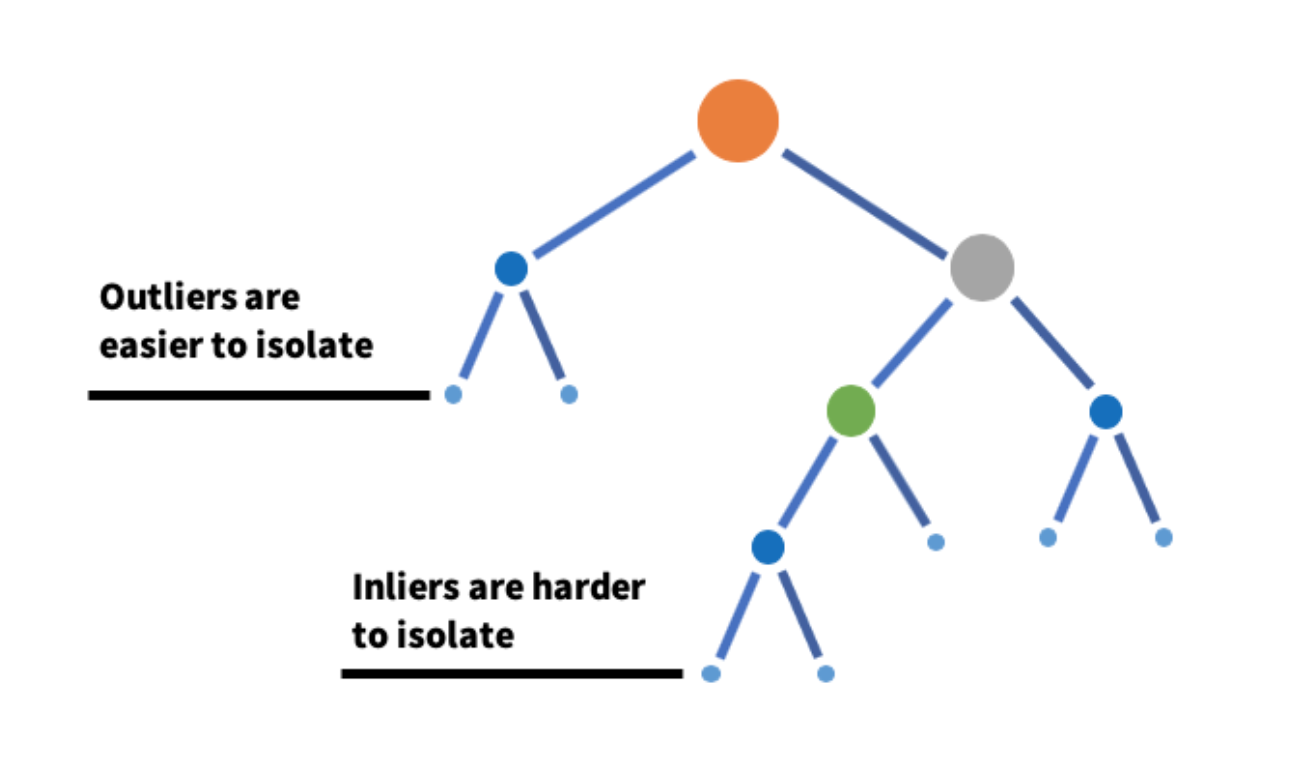
Source: Linkedin Learning: [Isolation Forest](https://engineering.linkedin.com/blog/2019/isolation-forest)

####  Training an Isolation Forest 

To train an Isollation Forest we use the Scikit-learn library. This library implements most ML models and proivdes a convenient API. The trained model is saved into a .sav file. We will load the trained model later to evaluate its performance. 

Isolation forests do not need a testing dataset. They directly train with the training dataset. Any changes to the training need to be done with respect to the evaluation dataset. 

In [140]:
from sklearn.ensemble import IsolationForest
from time import perf_counter
import joblib

# We are using a subset of the training dataset. Does this make sense?
testing_samples = 600

tic = perf_counter()
model_if = IsolationForest(random_state =seed).fit(data_training.sample(n=testing_samples))
joblib.dump(model_if, 'ml_models/Isolation_Forest.sav')
toc = perf_counter()
t_if = toc-tic

In [120]:
print('The IF training time is:')
t_if

The IF training time is:


0.18054419300460722

#### Visualizing the Isolation Forest
We can plot one of the binary trees in the IsolationForest

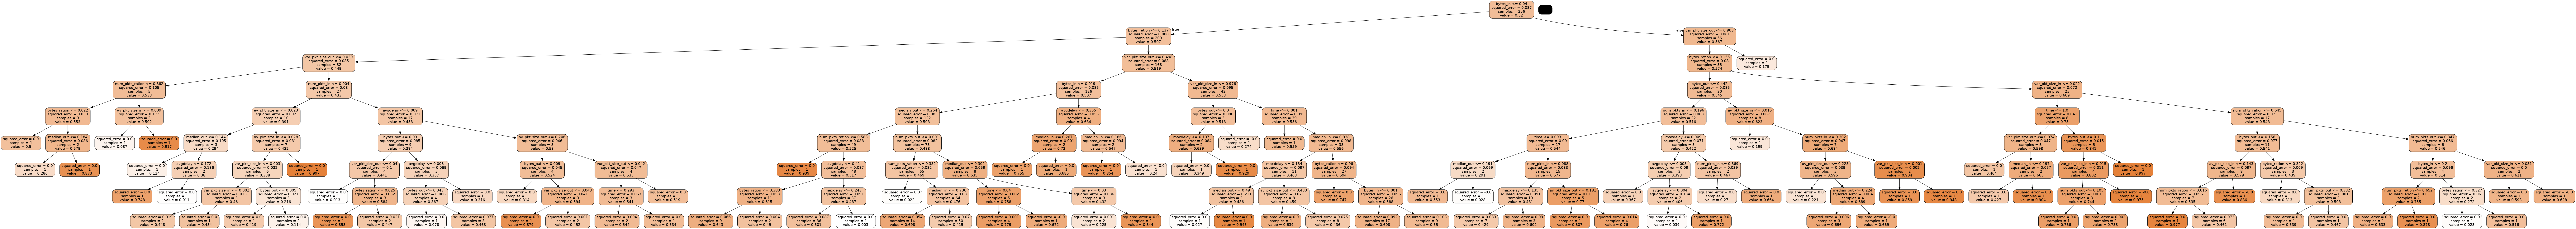

In [124]:
# Extract a binary tree from the IsolationForest object
tree = model_if.estimators_[0]

from sklearn.tree import export_graphviz
import pydot
import graphviz
from IPython.display import Image

graph_data = export_graphviz(
    tree,
    out_file="isolation_tree.dot",
    feature_names=data_training.columns.to_list(),
    class_names=['normal', 'malicious'],
    rounded=True,
    filled=True
)


'''
Convert the .dot file to .png
'''
(graph,) = pydot.graph_from_dot_file('isolation_tree.dot')
graph.write_png('isolation_tree.png')
Image('decision_tree.png')

The first line in every nodes is the feature value threshold used to split the dataset. Samples denotes the number of samples that fall under the nodes. Value and squared error are values used to measure how well the node partitions the data.  

### Evaluating the Isolation Forest
We can now evaluate how well our trained isolation forest can indentify malicious DoH traffic. We do this be asking it to assign an anomaly score to each sample in our evaluation dataset. A high anomaly score corresponds to malicious data and a low anomaly score represents normal data. However, how high should the anomaly score be is hard to tell until we test it. Next, we calculate several performance metrics for the isolation forest. But first we define a few helper functions. 

### Helper Functions

In [99]:
#Import ML metrics
from sklearn.metrics import roc_curve, auc, precision_recall_curve, roc_auc_score, f1_score, average_precision_score, \
confusion_matrix, precision_score, recall_score, accuracy_score

# Function to predict labels based on the best threshold. 
def predict_labels(fpr, tpr, thresholds, data):

    # Calculate best ROC threshold  using the Youden index
    #J_index = tpr-fpr
    #best = np.argmax(J_index)
    threshold = thresholds[np.argmax(tpr-fpr)] # Point on ROC curve colsest to the top-left corner.

    # Predict the labels
    predicted_labels_roc = data.copy()
    predicted_labels_roc[data>threshold]  = -1
    predicted_labels_roc[data<=threshold] = 1
    #if threshold>1:
    #    print("threshold is greater than the label (1). All predicted labels are arbitrairly 0")

    return predicted_labels_roc

# Function to calculate metrics and save to a dataframe
def get_metrics(true_labels, predicted_labels, scores, positive_label=-1):

        # calculate and save accuracy, precision, recall, and f1-score
        acc = accuracy_score(true_labels, predicted_labels)
        prec = precision_score(true_labels, predicted_labels)
        rec = recall_score(true_labels, predicted_labels)
        f1 = f1_score(true_labels, predicted_labels)
        auc = roc_auc_score(true_labels*-1, scores)
        ap = average_precision_score(true_labels*-1,scores,pos_label=positive_label)

        tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels).ravel()
        fpr = fp/(fp+tn)


        # Save the metrics
        metricNames = ['accuracy','precision', 'recall(TPR)', 'FPR', 'f1-score', 'AUC','AP','TN', 'FP', 'FN', 'TP']
        d = {'metric':metricNames,
              'value':[acc, prec, rec, fpr, f1, auc, ap, tn, fp, fn, tp]}
        df = pd.DataFrame(data=d)

        return df

### Receiver Operating Characteristic Curve

The ROC curve is a measure of how well the model can understand the data. An ideal ROC curve goes straight up from (0,0) to (0,1), and then across to (1,1). The worst ROC curve is a diagonal line from (0,0) to (1,1). The ROC curve also helps us find the best anomaly detection score to use as a threshold. 

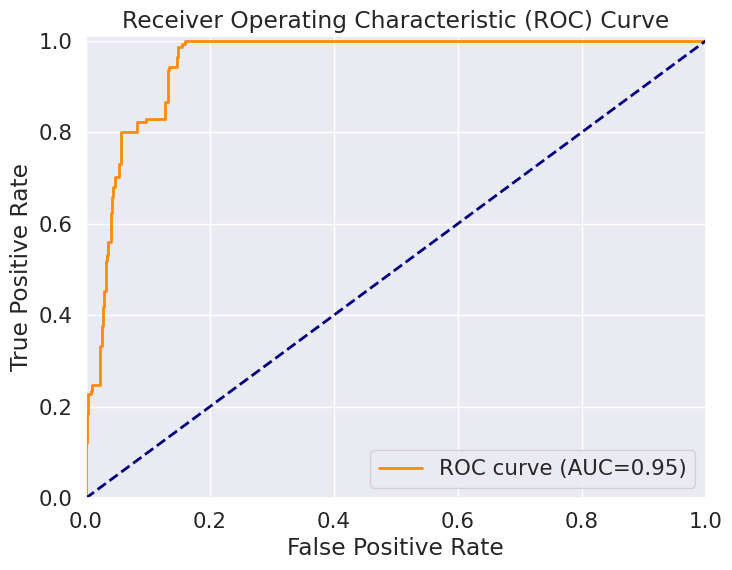

In [141]:
# Get anomaly scores for samples in the evaluation dataset
scores_if  = model_if.decision_function(data_evaluation)*-1

# Set the positive label to make it consistent across models. 
positive_label=-1


# Get the Receiver Operator Curve 
fpr, tpr, thresholds = roc_curve(evaluation_labels, scores_if, pos_label=positive_label)

# Calculate the area under the curve
roc_auc = auc(fpr, tpr)

#Visualize the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC={roc_auc:.2f})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Final ML model metrics
Based on the threshold we found with the ROC curve we predict whether the samples are normal or malicious 

In [142]:
# Use the isolation forest to predic the labels
predicted_labels     = predict_labels(fpr, tpr, thresholds, scores_if)

# Calculate the labels
metrics_if           = get_metrics(evaluation_labels, predicted_labels, scores_if)

In [143]:
metrics_if

,metric,value
0,accuracy,0.875614
1,precision,0.997475
2,recall(TPR),0.840426
3,FPR,0.007092
4,f1-score,0.912240
5,AUC,0.953176
6,AP,0.569138
7,TN,140.000000
8,FP,1.000000
9,FN,75.000000


In [ ]:
## Confusion Matrix
The confusion matrix allows us to see how many samples were misclassified. 

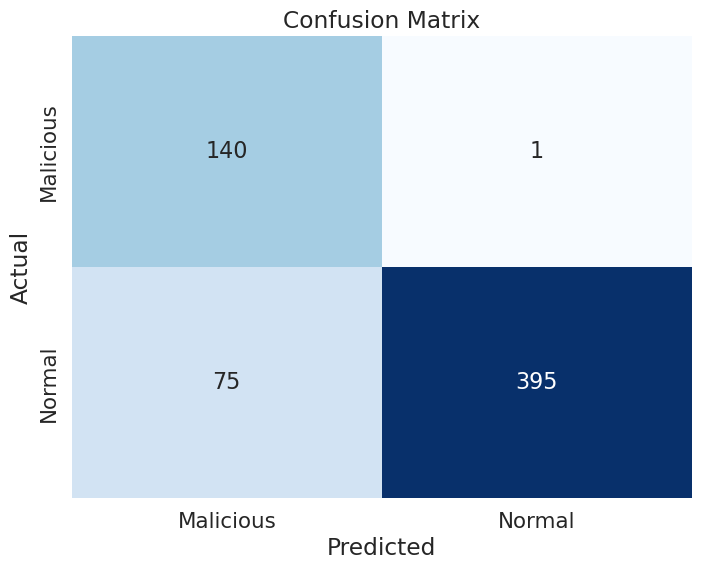

In [144]:
# Plot the confusion matrix
import seaborn as sns


# Confusion matrix
cm = confusion_matrix(evaluation_labels, predicted_labels)

sns.set(font_scale=1.4)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size":16}, cbar=False, \
           xticklabels = ['Malicious','Normal'], yticklabels = ['Malicious','Normal'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Can you improve the performance? 

There are several ways to improve the performance of Isolation Forests. 
   1. Use more data for training. Are we using all samples ?
   2. Use more (or less) trees. Default value for nestimators =100. 
   3. Use more (or less) features per tree. Default is 1. 
   4. Bootstrap. Default is False. If true, we allow trees to train on overlapping subsets. 
   5. Number of samples per tree. 

### Local Outlier Factor

Local outlier factor (LOF) calculates the density of neighbors for each sample in the dataset. Samples with low density are considered outliers. The density tells us how isolated a samples is from other samples. If the sample's nighbors have many neighbors but our sample doesn't, it is an outlier. The size of the circles in the figure show the outlier score (inverse of density). 

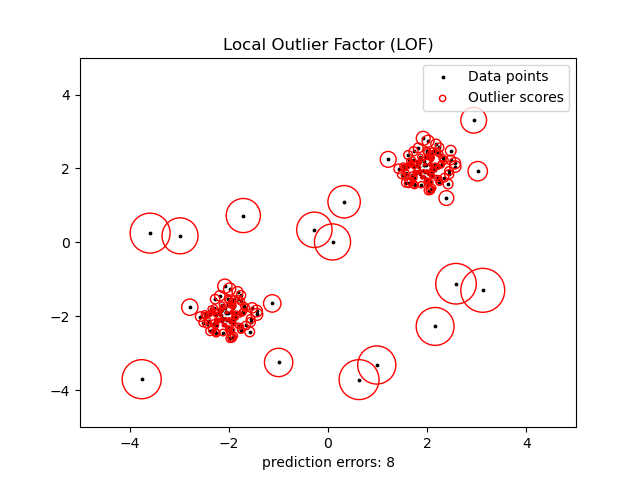
Source: [Scikit-Learn](https://scikit-learn.org/stable/auto_examples/neighbors/plot_lof_outlier_detection.html)

####  Training a Local Outlier Factor Model
Similarly to Isolation forests, LOFs do not need a testing dataset. They directly train with the training dataset. 

In [145]:
from sklearn.neighbors import LocalOutlierFactor

testing_samples = 600

tic = perf_counter()
model_lof = LocalOutlierFactor(novelty=True).fit(data_training.sample(n=testing_samples))
joblib.dump(model_lof, 'ml_models/Local_Outlier_Factor.sav')
toc = perf_counter()
t_lof = toc-tic

In [146]:
print('The LOF training time is:')
t_lof

The LOF training time is:


0.04052010401210282

### LOF Evaluation
The evaluation steps are the same for any ML model. 

In [ ]:
# Get anomaly scores for samples in the evaluation dataset
scores_lof  = model_lof.decision_function(data_evaluation)*-1

# Plot ROC Curve

#Plot Confusion Matrix

### Improving LOF Performance
By changing the parameters of LOF we can sometimes improve the performance,

 1. Number of neighbors used to compute the neighbor algorithm. 
 2. Distance metric. This metric calculates the distance to other samples from every sample in the dataset. In LOF, it tells us how close the evaluation samples are to training sample clusters. Depending on how the data is distributed in the hyperspace different metrics may have better results. 
 3. 

## Performance Comparison
Which one had a better accuracy, precision, recall, F1-scores, etc.?
Which one had a faster training time? 